# Quantum Error Correction

Neste tutorial, discutiremos os algoritmos básicos para correções de erros quânticos. Estes algoritmos fornecem maneiras de corrigir erros quânticos, uma vez que são muito frágeis e propensos a erros devido à decoherência e outros ruídos quânticos. [1-2]. Eles são _Bit Flip Code_, _Phase Flip Code_, e _Shor Code_ e serão implementados em Qiskit


[1] https://en.wikipedia.org/wiki/Quantum_error_correction

[2] https://quantumcomputinguk.org/tutorials/quantum-error-correction-phase-flip-code-in-qiskit


In [1]:
import numpy as np
from random import random

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.visualization import plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector
from qiskit.circuit import Parameter

### Bit Flip Code

Primeiro, veremos como o bit flip pode ser corrigido em um circuito quântico. Em um computador quântico, isso significa a transição de $ |0\rangle \to  |1\rangle$ ou vice-versa.

Os bits invertidos são a fonte de erro tanto na computação clássica quanto na quântica. No primeiro caso, um código de repetição suprime o erro de inversão de bit. No entanto, a mesma abordagem não funciona para um canal quântico. Em geral, como não é possível repetir um único qubit três vezes (teorema no-cloning), recorre-se a outro método para superar esta questão. Neste caso, aplicamos o código quântico de três bits proposto pela primeira vez por Asher Peres [3]. Esta técnica utiliza características quânticas como emaranhamento e se assemelha ao código de repetição.

[3] Peres, Asher (1985). "Reversible Logic and Quantum Computers". Physical Review A. 32 (6): 3266–3276.

Para o propósito declarado anteriormente, implementaremos o _Bit Flip Code_. Em primeiro lugar, vamos gerar um estado aleatório incial $|\psi\rangle$ para o qubit de interesse (qubit 0), que será considerado ao longo desse tutorial.

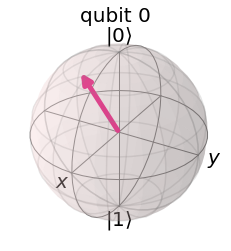

In [2]:
psi = random_statevector(2)
init_gate = Initialize(psi)

plot_bloch_multivector(psi)

Agora, nós implementamos o circuito que realiza tal correção de erro

In [3]:
num_qubits = 3

qc = QuantumCircuit(num_qubits)

#Random state for Bob
qc.append(init_gate, [0])
qc.barrier()

#Part1: cx gate + hadarmad
for ii in range(num_qubits-1):
    qc.cx(0,ii+1) 

for ii in range(num_qubits):
    qc.h(ii) 
    
qc.barrier()

O erro de inversão de bit é implementado através do gate `Rz` aplicado ao primeiro qubit com ângulo aleatório $\theta_0$

In [4]:
#Part2: bit flp 
theta = random()
aux = QuantumCircuit(num_qubits)

aux.rz(theta,0)
aux.barrier()

O cirrcuit completo é

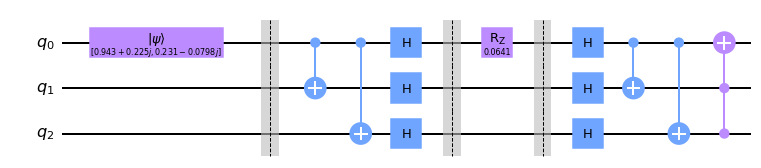

In [5]:
#Part3: hadarmad + cx gate + ccx gate

for ii in range(num_qubits):
    aux.h(ii) 

for ii in range(num_qubits-1):
    aux.cx(0,ii+1)

aux.ccx(2,1,0)

#composing
bit_flip = qc.compose(aux)

bit_flip.draw('mpl')

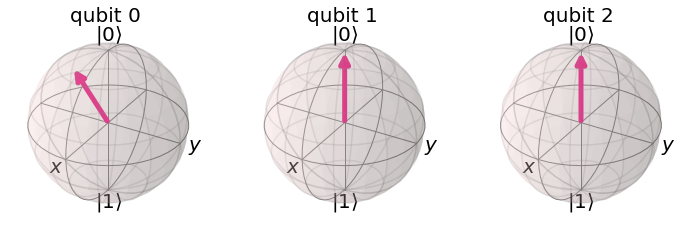

In [6]:
sim = Aer.get_backend('aer_simulator')

bit_flip.save_statevector()
out_vector = sim.run(bit_flip).result().get_statevector()
plot_bloch_multivector(out_vector)

### Phase Flip Code

Para computadores quânticos há outra fonte de erro, que é a inversão de fase. Isso significa que, através da transmissão em canal quatnum, o sinal relativo entre $ |0\rangle $  e $ |1\rangle$ pode se tornar invertido. Agora, consideramos como uma inversão de fase pode ser corrigida usando o _Código de inversão de fase_. Vamos simular um erro de inversão de fase aplicando um gate `Rx` ao primeiro qubit com ângulo aleatório  $\theta_1$

In [7]:
#Part2: Phase 
theta1 = random()
aux1 = QuantumCircuit(num_qubits)

aux1.rx(theta1,0)
aux1.barrier()

O circuito completo é

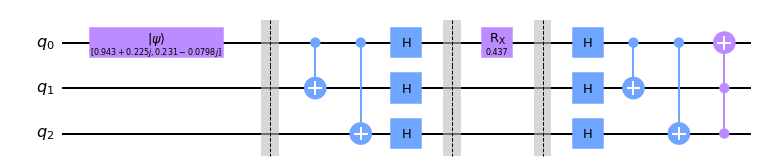

In [8]:
#Part3: hadarmad + cx gate + ccx gate

for ii in range(num_qubits):
    aux1.h(ii) 

for ii in range(num_qubits-1):
    aux1.cx(0,ii+1)

aux1.ccx(2,1,0)

#composing
phase_flip = qc.compose(aux1)

phase_flip.draw('mpl')

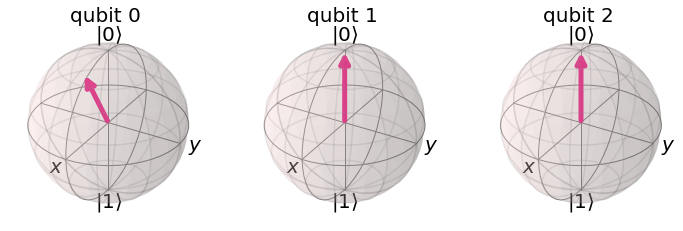

In [9]:
phase_flip.save_statevector()
out_vector1 = sim.run(phase_flip).result().get_statevector()
plot_bloch_multivector(out_vector1)

Note, temos o mesmo estado que costumávamos ter inicialmente

### Shor Code: erros de bit e phase flip

Finalmente, consideramos o cenário completo, onde os erros de bit e phase flips acontecem. Para este fim, implementaremos o código curto para tal correção de erros. Neste caso, precisamos de 9 qubits e os bit e phase flips são dados aplicando aos `Rx` e `Rz` sequencialmente. O circuito é

In [10]:
shor_code, aux_shor, aux_shor1 = QuantumCircuit(9), QuantumCircuit(9), QuantumCircuit(9)

#auxiliary circuits
aux_shor.cx(0,3)
aux_shor.cx(0,6) 
aux_shor.h([0,3,6])

ii=0
while ii < 9:
    aux_shor1.cx(ii,ii+1)
    aux_shor1.cx(ii,ii+2)
    ii+=3 

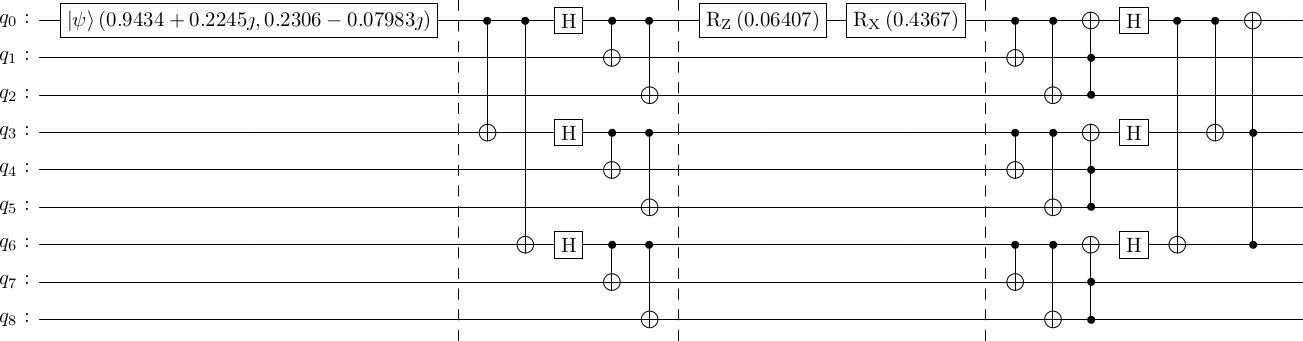

In [11]:
#Part1: Random state for qubit 0
shor_code.append(init_gate, [0])
shor_code.barrier()

#Part2: cx gate + hadarmad
shor_code = shor_code.compose(aux_shor).compose(aux_shor1)
    
#Part3: phase and bit errors with some random angle 
shor_code.barrier()
shor_code.rz(theta, 0)
shor_code.rx(theta1, 0)
shor_code.barrier()

#Part4: cx gate + ccx + hadarmad + ccx
shor_code = shor_code.compose(aux_shor1)

for ii in range(9):
    if ii%3 == 0: 
        shor_code.ccx(ii+2,ii+1,ii)
        
shor_code =  shor_code.compose(aux_shor.inverse())
shor_code.ccx(6,3,0)

shor_code.draw('latex')

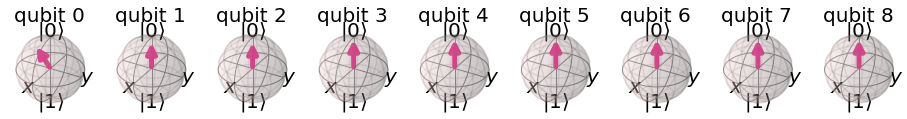

In [12]:
shor_code.save_statevector()
output2 = sim.run(shor_code).result().get_statevector()
plot_bloch_multivector(output2)

Note que em todos esses casos (em bit e phase flips, e no Shor code), restauramos quase que exatamente no qubit 0 o estado inicial $|\psi\rangle$, o mesmo gerado no início deste tourorial.